In [ ]:
# Remarques :

"""
On entraîne un modèle/ On crée un arbre à chaque prédiction
fonction utilisée : valeur absolue moyenne -> symétrie
"""

In [1]:
# IMPORTS :

import numpy as np
from pandas import *

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [2]:
# Data :

df = read_csv('Days.csv')
df["Date"] = to_datetime(df['timestamp'])
df.set_index(['Date'],inplace=True)

df = DataFrame(df, columns=['Y'])

df

,Y
Date,
2007-01-01,1.908564
2007-01-02,0.881414
2007-01-03,0.704204
2007-01-04,2.263481
2007-01-05,1.884281
...,...
2009-12-27,1.524619
2009-12-28,1.454235
2009-12-29,1.422200


In [3]:
# transform a time series dataset into a supervised learning dataset
# 1 last -> 1 next/pred
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [4]:
series_to_supervised(df, n_in=1, n_out=1, dropnan=True)

array([[1.90856428, 0.88141389],
       [0.88141389, 0.70420417],
       [0.70420417, 2.26348056],
       ...,
       [1.45423472, 1.4222    ],
       [1.4222    , 1.70215972],
       [1.70215972, 0.342     ]])

In [5]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	len_test = len(test)
	for i in range(len_test):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
		print(i,len_test)
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

In [6]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [7]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

>expected=0.8, predicted=1.2
0 12
>expected=1.4, predicted=1.0
1 12
>expected=1.3, predicted=1.2
2 12
>expected=1.0, predicted=1.3
3 12
>expected=2.0, predicted=1.2
4 12
>expected=1.5, predicted=1.9
5 12
>expected=1.5, predicted=1.2
6 12
>expected=1.5, predicted=1.4
7 12
>expected=1.5, predicted=1.6
8 12
>expected=1.4, predicted=1.2
9 12
>expected=1.7, predicted=1.5
10 12
>expected=0.3, predicted=1.4
11 12
MAE: 0.377


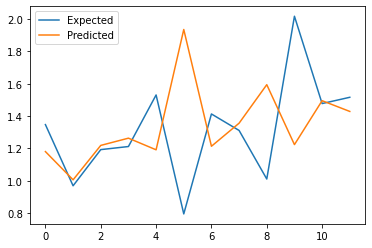

In [8]:
# MAIN :

# load the dataset
series = df
values = df.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()